In [1]:
#hide
! [ -e /content ] && pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

'[' is not recognized as an internal or external command,
operable program or batch file.


In [2]:
#hide
from fastbook import *

## Multi-Label Classification

In [3]:
from fastai.vision.all import *
path = untar_data(URLs.PASCAL_2007)

In [4]:
df = pd.read_csv(path/'train.csv')
df.head()

,fname,labels,is_valid
0,000005.jpg,chair,True
1,000007.jpg,car,True
2,000009.jpg,horse person,True
3,000012.jpg,car,False
4,000016.jpg,bicycle,True


In [5]:
df.iloc[:,0] # First column

0       000005.jpg
1       000007.jpg
2       000009.jpg
3       000012.jpg
4       000016.jpg
           ...    
5006    009954.jpg
5007    009955.jpg
5008    009958.jpg
5009    009959.jpg
5010    009961.jpg
Name: fname, Length: 5011, dtype: object

In [6]:
df.iloc[0,:] # First row

# Trailing :s are always optional (in numpy, pytorch, pandas, etc.),
#   so this is equivalent:
df.iloc[0]

fname       000005.jpg
labels           chair
is_valid          True
Name: 0, dtype: object

In [7]:
df['fname'] # Access a column by name

0       000005.jpg
1       000007.jpg
2       000009.jpg
3       000012.jpg
4       000016.jpg
           ...    
5006    009954.jpg
5007    009955.jpg
5008    009958.jpg
5009    009959.jpg
5010    009961.jpg
Name: fname, Length: 5011, dtype: object

In [8]:
tmp_df = pd.DataFrame({'a':[1,2], 'b':[3,4]})
tmp_df

,a,b
0,1,3
1,2,4


In [9]:
tmp_df['c'] = tmp_df['a']+tmp_df['b']
tmp_df

,a,b,c
0,1,3,4
1,2,4,6


### End sidebar

### Constructing a DataBlock

In [10]:
dblock = DataBlock()

In [11]:
dsets = dblock.datasets(df)

In [12]:
len(dsets.train),len(dsets.valid)

(4009, 1002)

In [17]:
x,y = dsets.train[0]
print(f'x: {x}')
print(f'y: {y}')

x: fname       008663.jpg
labels      car person
is_valid         False
Name: 4346, dtype: object
y: fname       008663.jpg
labels      car person
is_valid         False
Name: 4346, dtype: object


In [14]:
x['fname']

'008663.jpg'

In [18]:
dblock = DataBlock(get_x = lambda r: r['fname'], get_y = lambda r: r['labels'])
dsets = dblock.datasets(df)
dsets.train[0]

('005620.jpg', 'aeroplane')

In [19]:
def get_x(r): return r['fname']
def get_y(r): return r['labels']
dblock = DataBlock(get_x = get_x, get_y = get_y)
dsets = dblock.datasets(df)
dsets.train[0]

('002549.jpg', 'tvmonitor')

In [20]:
def get_x(r): return path/'train'/r['fname']
def get_y(r): return r['labels'].split(' ')
dblock = DataBlock(get_x = get_x, get_y = get_y)
dsets = dblock.datasets(df)
dsets.train[0]

(Path('C:/Users/jared/.fastai/data/pascal_2007/train/002844.jpg'), ['train'])

In [21]:
dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   get_x = get_x, get_y = get_y)
dsets = dblock.datasets(df)
dsets.train[0]

(PILImage mode=RGB size=500x375,
 TensorMultiCategory([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]))

In [22]:
idxs = torch.where(dsets.train[0][1]==1.)[0]
dsets.train.vocab[idxs]

(#1) ['dog']

In [24]:
def splitter(df):
    train = df.index[~df['is_valid']].tolist()
    valid = df.index[df['is_valid']].tolist()
    return train,valid

dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   splitter=splitter,
                   get_x=get_x, 
                   get_y=get_y)

dsets = dblock.datasets(df)
dsets.train[0]

(PILImage mode=RGB size=500x333,
 TensorMultiCategory([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))

In [26]:
dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   splitter=splitter,
                   get_x=get_x, 
                   get_y=get_y,
                   item_tfms = RandomResizedCrop(128, min_scale=0.35))
dls = dblock.dataloaders(df)

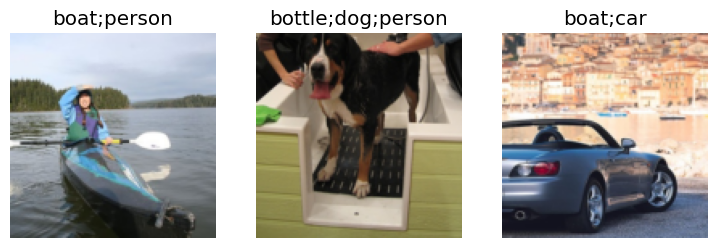

In [27]:
dls.show_batch(nrows=1, ncols=3)

### Binary Cross-Entropy

In [28]:
learn = vision_learner(dls, resnet18)

In [29]:
x,y = to_cpu(dls.train.one_batch())
activs = learn.model(x)
activs.shape

torch.Size([64, 20])

In [30]:
activs[0]

TensorImage([ 2.3446, -2.2410,  1.2411, -1.5623, -3.5006, -0.5543,  0.1616,  1.9561, -0.7403, -2.2096,  4.5200,  0.1635, -0.3698, -2.7330, -1.8717, -2.4791,  2.3504, -0.0146,  2.3073,  0.9946],
            grad_fn=<AliasBackward0>)

In [38]:
def binary_cross_entropy(inputs, targets):
    inputs = inputs.sigmoid()
    return -torch.where(targets==1, inputs, 1-inputs).log().mean()

In [40]:
loss_func = nn.BCEWithLogitsLoss()
loss = loss_func(TensorBase(activs), TensorBase(y))
loss

TensorBase(1.0826, grad_fn=<AliasBackward0>)

In [44]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
print(f"pytorch version: {torch.__version__}")

Using device: cuda
pytorch version: 2.4.0+cu124


In [45]:
learn = vision_learner(dls, resnet50, metrics=partial(accuracy_multi, thresh=0.2))
learn.fine_tune(3, base_lr=3e-3, freeze_epochs=4)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.951811,0.702805,0.230876,00:16
1,0.825368,0.526947,0.298825,00:16
2,0.597931,0.190920,0.829661,00:15
3,0.354325,0.115411,0.947171,00:16


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.126112,0.102844,0.951096,00:15
1,0.111843,0.097642,0.955618,00:16
2,0.096894,0.094144,0.958466,00:16


In [46]:
learn.metrics = partial(accuracy_multi, thresh=0.1)
learn.validate()

(#2) [0.09414432942867279,0.9419519901275635]

In [47]:
learn.metrics = partial(accuracy_multi, thresh=0.99)
learn.validate()

(#2) [0.09414432942867279,0.9427888989448547]

In [48]:
preds,targs = learn.get_preds()

In [49]:
accuracy_multi(preds, targs, thresh=0.9, sigmoid=False)

TensorBase(0.9585)

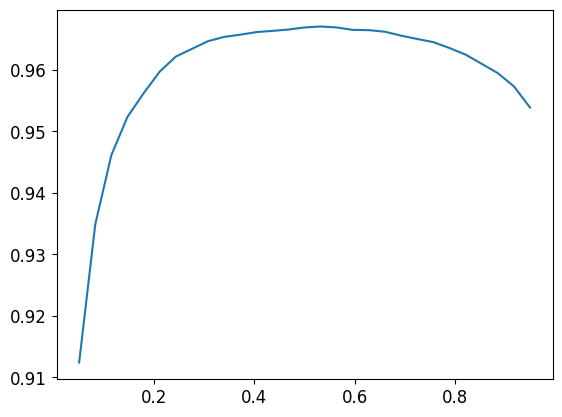

In [50]:
xs = torch.linspace(0.05,0.95,29)
accs = [accuracy_multi(preds, targs, thresh=i, sigmoid=False) for i in xs]
plt.plot(xs,accs);

## Regression

In [51]:
path = untar_data(URLs.BIWI_HEAD_POSE)

In [52]:
#hide
Path.BASE_PATH = path

In [53]:
path.ls().sorted()

(#50) [Path('01'),Path('01.obj'),Path('02'),Path('02.obj'),Path('03'),Path('03.obj'),Path('04'),Path('04.obj'),Path('05'),Path('05.obj')...]

In [54]:
(path/'01').ls().sorted()

(#1000) [Path('01/depth.cal'),Path('01/frame_00003_pose.txt'),Path('01/frame_00003_rgb.jpg'),Path('01/frame_00004_pose.txt'),Path('01/frame_00004_rgb.jpg'),Path('01/frame_00005_pose.txt'),Path('01/frame_00005_rgb.jpg'),Path('01/frame_00006_pose.txt'),Path('01/frame_00006_rgb.jpg'),Path('01/frame_00007_pose.txt')...]

In [55]:
img_files = get_image_files(path)
def img2pose(x): return Path(f'{str(x)[:-7]}pose.txt')
img2pose(img_files[0])

Path('01/frame_00003_pose.txt')

In [56]:
im = PILImage.create(img_files[0])
im.shape

(480, 640)

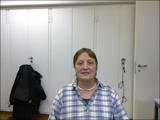

In [57]:
im.to_thumb(160)

In [58]:
cal = np.genfromtxt(path/'01'/'rgb.cal', skip_footer=6)
def get_ctr(f):
    ctr = np.genfromtxt(img2pose(f), skip_header=3)
    c1 = ctr[0] * cal[0][0]/ctr[2] + cal[0][2]
    c2 = ctr[1] * cal[1][1]/ctr[2] + cal[1][2]
    return tensor([c1,c2])

In [59]:
get_ctr(img_files[0])

tensor([350.4915, 262.9643])

In [60]:
biwi = DataBlock(
    blocks=(ImageBlock, PointBlock),
    get_items=get_image_files,
    get_y=get_ctr,
    splitter=FuncSplitter(lambda o: o.parent.name=='13'),
    batch_tfms=aug_transforms(size=(240,320)), 
)

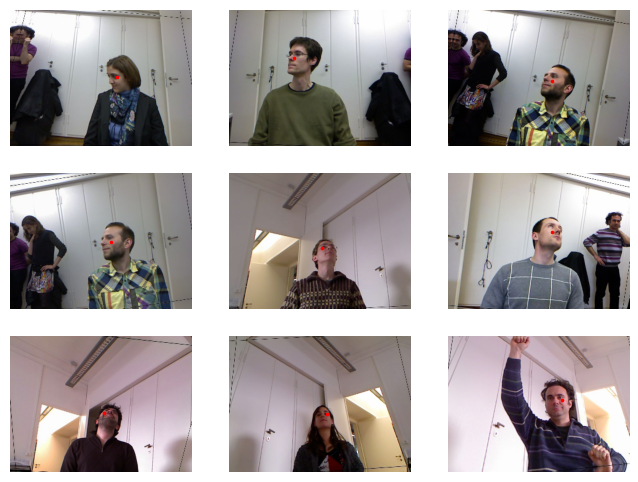

In [61]:
dls = biwi.dataloaders(path)
dls.show_batch(max_n=9, figsize=(8,6))

In [62]:
xb,yb = dls.one_batch()
xb.shape,yb.shape

(torch.Size([64, 3, 240, 320]), torch.Size([64, 1, 2]))

In [63]:
yb[0]

TensorPoint([[ 0.0262, -0.0433]], device='cuda:0')

### Training a Model

In [64]:
learn = vision_learner(dls, resnet18, y_range=(-1,1))

In [65]:
def sigmoid_range(x, lo, hi): return torch.sigmoid(x) * (hi-lo) + lo

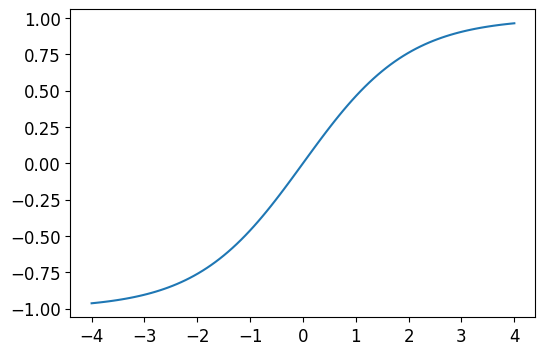

In [66]:
plot_function(partial(sigmoid_range,lo=-1,hi=1), min=-4, max=4)

In [67]:
dls.loss_func

FlattenedLoss of MSELoss()

c:\Users\jared\Documents\fastai_repo\fastbook\fastai_venv\Lib\site-packages\fastai\learner.py:51: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_

SuggestedLRs(valley=0.0010000000474974513)

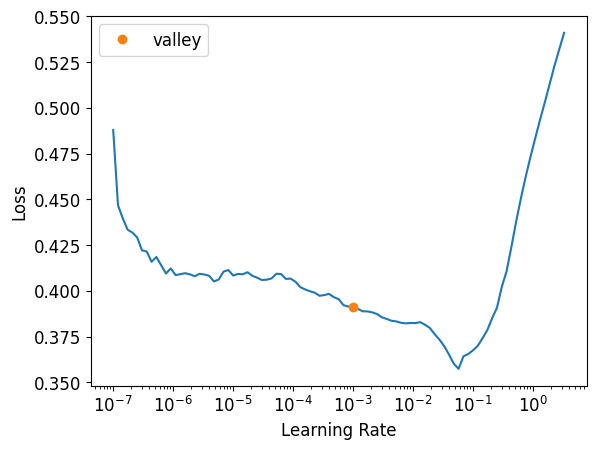

In [68]:
learn.lr_find()

In [69]:
lr = 1e-2
learn.fine_tune(3, lr)

epoch,train_loss,valid_loss,time
0,0.046867,0.011502,01:53


epoch,train_loss,valid_loss,time
0,0.008968,0.005717,01:01
1,0.003086,0.000181,01:00
2,0.001401,0.000074,01:01


In [70]:
math.sqrt(0.0001)

0.01

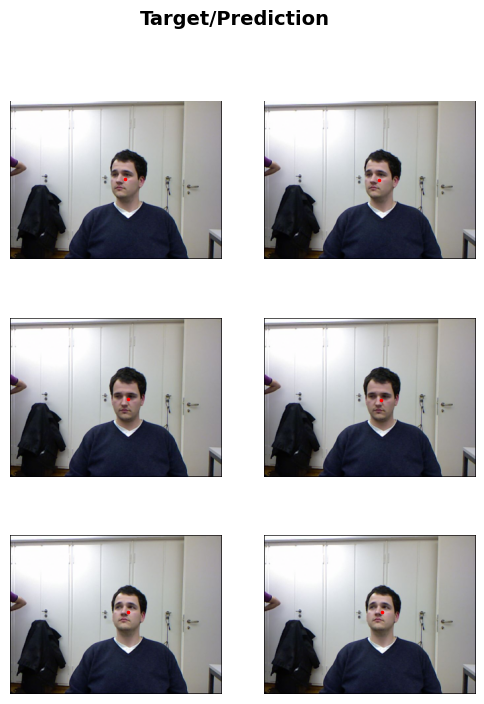

In [71]:
learn.show_results(ds_idx=1, nrows=3, figsize=(6,8))